In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ap import PointNetAbstractorPredictor
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data,\
                                                points_w_normals_extension

from tf_lab.autopredictors.scripts import virt_scan_data as vscan

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

In [38]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
complete_n_samples = 4096
incomplete_n_samples = 2048

predict_normals = True
# experiment_name = '10_vscan_emd_' + str(incomplete_n_samples) + '_' + str(complete_n_samples) + 'pts'
experiment_name = 'scratch'

do_training = True
do_plotting = False
first_time_running = True
load_model = False

class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]

n_input = [incomplete_n_samples, 3]
n_output = [complete_n_samples, 3]

if predict_normals:
    n_extra_pred = [complete_n_samples, 3]
    decoder_last_dim = n_output[0]  * (n_output[1] + n_extra_pred[1])
else:
    n_extra_pred = None
    decoder_last_dim = np.prod(n_output)

Give me the class type.
chair


In [7]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'

full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/', \
                             str(complete_n_samples) + '_with_normals', class_syn_id)


train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/')
train_dir = osp.join(train_dir, experiment_name)

create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch'

In [8]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, points_w_normals_extension)

full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, \
                                                                        loader=pio._load_crude_pcloud_with_normal_and_model_info,\
                                                                        n_threads=25)


print '%d files containing complete point clouds with normals were found.' % (len(full_pclouds), )


# TODO: !!!! LIN LIN LIN !!! TRIPLE CHECK THE Normals here are as in the input files.
# eg. run:
# full_pclouds = full_pclouds[:,:,:3]
# full_pclouds_normals = full_pclouds[:,:,3:]
# i = 0
# points = full_pclouds[i]
# normals = full_pclouds_normals[i]

6778 files containing complete point clouds with normals were found.


In [9]:
v_scan_top_dir = osp.join(top_data_dir, 'From_Matthias/shapenet_dim32_sdf_pc', class_syn_id)
search_pattern = '.ply'
    
if do_training:
    train_id_file = osp.join(top_data_dir, 'From_Matthias/train_test_models/train_models_with_scan_id.txt')
    
    train_data = vscan.load_single_class_incomplete_dataset(v_scan_top_dir, train_id_file, class_syn_id,
                                                      full_pclouds, full_model_names, n_threads=25,
                                                      n_samples=incomplete_n_samples, search_pattern=search_pattern)

else:
    test_id_file = osp.join(top_data_dir, 'From_Matthias/train_test_models/test_models_with_scan_id.txt')
    test_data = vscan.load_single_class_incomplete_dataset(v_scan_top_dir, test_id_file, class_syn_id, 
                                                      full_pclouds, full_model_names, n_threads=25,
                                                      n_samples=incomplete_n_samples, search_pattern=search_pattern)

30000 incomplete point clouds were loaded.


0.703125 0.25


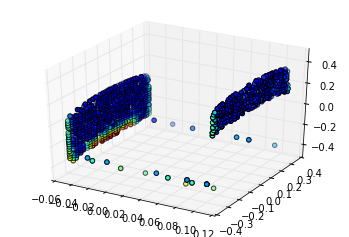

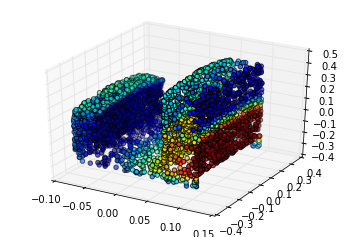

In [25]:
# # TRY ME to see that the matched chairs are ok.
from tf_lab.autopredictors.evaluate import accuracy_of_completion, coverage_of_completion

pp = train_data.next_batch(1)
pinc = pp[2].reshape(n_input)
pcom = pp[0][:, :, :3].reshape(complete_n_samples, 3)

    
score1, c1 = accuracy_of_completion(pinc, pcom, 0.02, ret_dists=True)
score2, c2 = coverage_of_completion(pcom, pinc, 0.02, ret_dists=True)
print score1, score2

Point_Cloud(points=pinc).plot(c=c1);
Point_Cloud(points=pcom).plot(c=c2);

In [ ]:
### if load_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:
    decoder_args = {'layer_sizes': [1024, decoder_last_dim],  # TODO - Try one layer deeper
                    'non_linearity': tf.nn.tanh
                   }
    
    encoder_args = {'non_linearity': tf.nn.tanh
                   }

    conf = Conf(
                n_input = n_input,
                denoising = True,
                training_epochs = 200,
                batch_size = 40,
                loss = 'emd',
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 10,
                learning_rate = 0.00002,
                gauss_augment = {'mu': 0, 'sigma': 0.01},
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                encoder_args = encoder_args,                
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args,                
               )
    
    
    conf.n_output = n_output   # TODO - Wrap seperately
    conf.n_extra_pred = n_extra_pred
    conf.consistent_io = False
    
    conf.relative_loss_weight = 1.0

    conf.experiment_name = experiment_name

    conf.save(osp.join(conf.train_dir, 'configuration'))

In [ ]:
reset_tf_graph()
set_visible_GPUs([0])
ap = PointNetAbstractorPredictor(experiment_name, conf)

if do_training:
    ap.train(train_data, conf)

else:
    saved_epochs = read_saved_epochs(conf.train_dir)
    ap.restore_model(train_dir, saved_epochs[-1])

('Epoch:', '0001', 'training time (minutes)=', '7.8131', 'loss=', '341.994445231')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0002', 'training time (minutes)=', '7.9235', 'loss=', '308.598082560')
('Epoch:', '0003', 'training time (minutes)=', '7.8532', 'loss=', '301.254497437')
('Epoch:', '0004', 'training time (minutes)=', '7.8573', 'loss=', '297.981218058')
('Epoch:', '0005', 'training time (minutes)=', '7.6615', 'loss=', '295.200077006')
('Epoch:', '0006', 'training time (minutes)=', '7.5923', 'loss=', '293.130433818')
('Epoch:', '0007', 'training time (minutes)=', '7.6311', 'loss=', '291.561189494')
('Epoch:', '0008', 'training time (minutes)=', '7.6069', 'loss=', '290.123930094')
('Epoch:', '0009', 'training time (minutes)=', '8.3251', 'loss=', '288.661193848')
('Epoch:', '0010', 'training time (minutes)=', '8.3264', 'loss=', '287.771317383')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0011', 'training time (minutes)=', '8.3016', 'loss=', '286.482546712')
('Epoch:', '0012', 'training time (minutes)=', '8.3045', 'loss=', '285.610590434')
('Epoch:', '0013', 'training time (minutes)=', '8.3193', 'loss=', '284.254070964')
('Epoch:', '0014', 'training time (minutes)=', '8.2846', 'loss=', '283.506002441')
('Epoch:', '0015', 'training time (minutes)=', '8.2594', 'loss=', '282.267714905')
('Epoch:', '0016', 'training time (minutes)=', '8.2778', 'loss=', '281.411277384')
('Epoch:', '0017', 'training time (minutes)=', '8.3283', 'loss=', '280.538183146')
('Epoch:', '0018', 'training time (minutes)=', '8.3348', 'loss=', '279.694577820')
('Epoch:', '0019', 'training time (minutes)=', '8.2403', 'loss=', '278.812169617')
('Epoch:', '0020', 'training time (minutes)=', '8.3397', 'loss=', '278.059869181')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-20 is not in all_model_checkpoint_paths. Manually adding it

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-20 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0021', 'training time (minutes)=', '8.2754', 'loss=', '277.106884338')
('Epoch:', '0022', 'training time (minutes)=', '8.2793', 'loss=', '276.610536784')
('Epoch:', '0023', 'training time (minutes)=', '8.2534', 'loss=', '275.753627930')
('Epoch:', '0024', 'training time (minutes)=', '8.3308', 'loss=', '275.184494161')
('Epoch:', '0025', 'training time (minutes)=', '8.3020', 'loss=', '274.372908651')
('Epoch:', '0026', 'training time (minutes)=', '8.3375', 'loss=', '273.910495402')
('Epoch:', '0027', 'training time (minutes)=', '8.3959', 'loss=', '273.570998332')
('Epoch:', '0028', 'training time (minutes)=', '8.3405', 'loss=', '272.776305908')
('Epoch:', '0029', 'training time (minutes)=', '8.2798', 'loss=', '272.137297994')
('Epoch:', '0030', 'training time (minutes)=', '8.3152', 'loss=', '271.589611796')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-30 is not in all_model_checkpoint_paths. Manually adding it

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-30 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0031', 'training time (minutes)=', '8.2955', 'loss=', '271.211762655')
('Epoch:', '0032', 'training time (minutes)=', '8.3493', 'loss=', '270.749200419')
('Epoch:', '0033', 'training time (minutes)=', '8.3077', 'loss=', '270.349071635')
('Epoch:', '0034', 'training time (minutes)=', '8.3191', 'loss=', '269.623665202')
('Epoch:', '0035', 'training time (minutes)=', '8.3394', 'loss=', '269.105979350')
('Epoch:', '0036', 'training time (minutes)=', '8.2892', 'loss=', '268.945307109')
('Epoch:', '0037', 'training time (minutes)=', '8.2958', 'loss=', '268.370752380')
('Epoch:', '0038', 'training time (minutes)=', '8.3342', 'loss=', '268.189568054')
('Epoch:', '0039', 'training time (minutes)=', '8.2804', 'loss=', '267.495517131')
('Epoch:', '0040', 'training time (minutes)=', '8.2615', 'loss=', '267.098128621')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-40 is not in all_model_checkpoint_paths. Manually adding it

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-40 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0041', 'training time (minutes)=', '8.4802', 'loss=', '266.999700826')
('Epoch:', '0042', 'training time (minutes)=', '8.3315', 'loss=', '266.229841003')
('Epoch:', '0043', 'training time (minutes)=', '8.2762', 'loss=', '266.103708964')
('Epoch:', '0044', 'training time (minutes)=', '8.2543', 'loss=', '265.661170247')
('Epoch:', '0045', 'training time (minutes)=', '8.4361', 'loss=', '265.438293803')
('Epoch:', '0046', 'training time (minutes)=', '8.3878', 'loss=', '265.010432068')
('Epoch:', '0047', 'training time (minutes)=', '8.3063', 'loss=', '264.400661438')
('Epoch:', '0048', 'training time (minutes)=', '8.2502', 'loss=', '264.333065186')
('Epoch:', '0049', 'training time (minutes)=', '8.2648', 'loss=', '264.010720642')
('Epoch:', '0050', 'training time (minutes)=', '8.3228', 'loss=', '263.496260905')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-50 is not in all_model_checkpoint_paths. Manually adding it

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-50 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0051', 'training time (minutes)=', '8.3117', 'loss=', '263.295673523')
('Epoch:', '0052', 'training time (minutes)=', '8.3598', 'loss=', '262.832752299')
('Epoch:', '0053', 'training time (minutes)=', '8.2342', 'loss=', '262.490048625')
('Epoch:', '0054', 'training time (minutes)=', '8.3292', 'loss=', '262.416049967')
('Epoch:', '0055', 'training time (minutes)=', '8.2643', 'loss=', '261.876702413')
('Epoch:', '0056', 'training time (minutes)=', '8.3436', 'loss=', '261.695336182')
('Epoch:', '0057', 'training time (minutes)=', '8.2582', 'loss=', '261.388454061')
('Epoch:', '0058', 'training time (minutes)=', '8.3006', 'loss=', '261.517243795')
('Epoch:', '0059', 'training time (minutes)=', '8.2465', 'loss=', '260.913428955')
('Epoch:', '0060', 'training time (minutes)=', '8.3040', 'loss=', '260.370037191')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-60 is not in all_model_checkpoint_paths. Manually adding it

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-60 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0061', 'training time (minutes)=', '8.3030', 'loss=', '260.419986776')
('Epoch:', '0062', 'training time (minutes)=', '8.2454', 'loss=', '259.971576538')
('Epoch:', '0063', 'training time (minutes)=', '8.3170', 'loss=', '259.489760539')
('Epoch:', '0064', 'training time (minutes)=', '8.2675', 'loss=', '259.201724711')
('Epoch:', '0065', 'training time (minutes)=', '8.2773', 'loss=', '258.840430339')
('Epoch:', '0066', 'training time (minutes)=', '8.3817', 'loss=', '259.096758952')
('Epoch:', '0067', 'training time (minutes)=', '8.3455', 'loss=', '258.511366882')
('Epoch:', '0068', 'training time (minutes)=', '8.3804', 'loss=', '258.333988831')
('Epoch:', '0069', 'training time (minutes)=', '8.2529', 'loss=', '258.049372843')
('Epoch:', '0070', 'training time (minutes)=', '8.2780', 'loss=', '257.847017639')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-70 is not in all_model_checkpoint_paths. Manually adding it

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-70 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0071', 'training time (minutes)=', '8.3682', 'loss=', '257.390771545')
('Epoch:', '0072', 'training time (minutes)=', '8.3114', 'loss=', '257.095316325')
('Epoch:', '0073', 'training time (minutes)=', '8.2876', 'loss=', '257.077219177')
('Epoch:', '0074', 'training time (minutes)=', '8.3500', 'loss=', '256.610642965')
('Epoch:', '0075', 'training time (minutes)=', '8.3455', 'loss=', '256.451844482')
('Epoch:', '0076', 'training time (minutes)=', '8.2418', 'loss=', '256.117039897')
('Epoch:', '0077', 'training time (minutes)=', '8.3187', 'loss=', '256.131797180')
('Epoch:', '0078', 'training time (minutes)=', '8.3616', 'loss=', '256.112557719')
('Epoch:', '0079', 'training time (minutes)=', '8.2607', 'loss=', '255.496020549')
('Epoch:', '0080', 'training time (minutes)=', '8.0253', 'loss=', '255.226318420')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-80 is not in all_model_checkpoint_paths. Manually adding it

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-80 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0081', 'training time (minutes)=', '7.9578', 'loss=', '255.179282328')
('Epoch:', '0082', 'training time (minutes)=', '7.9666', 'loss=', '254.708761739')
('Epoch:', '0083', 'training time (minutes)=', '7.9794', 'loss=', '254.742858500')
('Epoch:', '0084', 'training time (minutes)=', '8.1142', 'loss=', '254.552586955')
('Epoch:', '0085', 'training time (minutes)=', '8.1673', 'loss=', '254.228927429')
('Epoch:', '0086', 'training time (minutes)=', '8.1866', 'loss=', '254.373499064')
('Epoch:', '0087', 'training time (minutes)=', '8.3327', 'loss=', '253.658110881')
('Epoch:', '0088', 'training time (minutes)=', '8.3087', 'loss=', '253.686174011')
('Epoch:', '0089', 'training time (minutes)=', '8.2823', 'loss=', '253.609271952')
('Epoch:', '0090', 'training time (minutes)=', '8.3181', 'loss=', '252.895954834')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-90 is not in all_model_checkpoint_paths. Manually adding it

INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/scratch/models.ckpt-90 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0091', 'training time (minutes)=', '8.2509', 'loss=', '253.125929932')
('Epoch:', '0092', 'training time (minutes)=', '8.3612', 'loss=', '252.626444010')
('Epoch:', '0093', 'training time (minutes)=', '8.2960', 'loss=', '252.696608866')
('Epoch:', '0094', 'training time (minutes)=', '8.2520', 'loss=', '252.390750203')
('Epoch:', '0095', 'training time (minutes)=', '8.2791', 'loss=', '252.352716553')
('Epoch:', '0096', 'training time (minutes)=', '8.3148', 'loss=', '252.230537313')

In [10]:
if do_plotting:
    saved_epochs = read_saved_epochs(conf.train_dir)
#     plot_epochs = select_first_last_and_k(saved_epochs, 13)
#     stats = eval_model(ae, conf, [train_data, test_data], epochs=plot_epochs)
    top_save_dir = osp.join(conf.train_dir, 'model_evaluation')
#     plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)
    last_epoch = saved_epochs[-1]
#     save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
#     plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=100)    
    save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=100)